In [2]:
#imports

import quandl
import pandas as pd

import numpy as np

# visualization
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
%matplotlib inline

/Users/ikorovkin1/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# data pull from Quandl
reg = quandl.get("CHRIS/CME_RK2")
gas_m1 = quandl.get("CHRIS/CME_SG2")
gas_m2 = quandl.get("CHRIS/CME_SG3")

In [4]:
# pandas data processing
regrade = pd.DataFrame(reg)
regrade = regrade.dropna()
regrade = regrade[['Settle', 'Open Interest']]
regrade.columns = [['price_reg', 'OI_reg']]

gasoil_m1 = pd.DataFrame(gas_m1)
gasoil_m1 = gasoil_m1.dropna()
gasoil_m1 = gasoil_m1[['Settle', 'Open Interest']]
gasoil_m1.columns = [['price_m1', 'OI_m1']]

gasoil_m2 = pd.DataFrame(gas_m2)
gasoil_m2 = gasoil_m2.dropna()
gasoil_m2 = gasoil_m2[['Settle', 'Open Interest']]
gasoil_m2.columns = [['price_m2', 'OI_m2']]

gasoil = pd.concat([gasoil_m1, gasoil_m2], axis = 1)
gasoil['spread_m1m2'] = gasoil.price_m1 - gasoil.price_m2

df = pd.concat([gasoil, regrade], axis = 1)

# keep only business days
ts_days = pd.to_datetime(df.index.date)
bdays = pd.bdate_range(start=df.index[0].date(), end=df.index[-1].date())
df = df[ts_days.isin(bdays)]
df = df.dropna()

# filter daily glitch moves of over 6 standard deviations
stdev_filter = 6
df['spread_return'] = (df.spread_m1m2 - df.spread_m1m2.shift(1).fillna(value=0))
df['spread_return'][0] = 0
df['reg_return'] = (df.price_reg - df.price_reg.shift(1).fillna(value=0))
df['reg_return'][0] = 0
for i in range (0, 2):
    df = df[df.spread_return.diff(1).map(lambda x: not(abs(x)>stdev_filter*np.std(df.spread_return)))]
    
for i in range (0, 2):
    df = df[df.reg_return.diff(1).map(lambda x: not(abs(x)>stdev_filter*np.std(df.reg_return)))]
df = df.dropna()

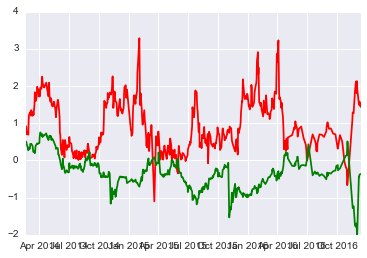

In [5]:
# visualize to check

plt.plot(df.index, df.price_reg, 'r', df.spread_m1m2, 'g')
plt.show()

In [6]:
# target = 1 if regrade is higher than 1.5 usd per bbl, 0 otherwise
df['target']= 0
df.loc[df.price_reg > 1.5, 'target'] = 1

In [7]:
df.head(5)

,price_m1,OI_m1,price_m2,OI_m2,spread_m1m2,price_reg,OI_reg,spread_return,reg_return,target
Date,,,,,,,,,,
2014-02-18,124.675,2539.0,124.172,1018.0,0.503,0.70,1075.0,0.000,0.00,0
2014-02-19,125.714,2559.0,125.205,1160.0,0.509,0.92,1075.0,0.006,0.22,0
2014-02-20,125.297,2559.0,124.802,1160.0,0.495,0.87,1075.0,-0.014,-0.05,0
2014-02-21,124.466,2556.0,124.031,1422.0,0.435,0.70,1075.0,-0.060,-0.17,0
2014-02-24,124.939,2717.0,124.575,1514.0,0.364,0.76,1075.0,-0.071,0.06,0


In [8]:
import pymc3 as pm

In [9]:
import theano.tensor as tt

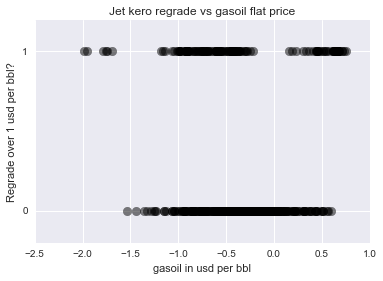

In [10]:
plt.scatter(df.spread_m1m2, df.target, s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Regrade over 1 usd per bbl?")
plt.xlabel("gasoil in usd per bbl")
plt.title("Jet kero regrade vs gasoil flat price");

In [11]:
# pymc3 model

levels = df.spread_m1m2
D = df.target # defect or not?

#notice the`value` here. We explain why below.
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*levels + alpha)))

In [12]:
# connect the probabilities in `p` with our observations through a
# Bernoulli random variable.
with model:
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    
    # Mysterious code to be explained in Chapter 3
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start)
    burned_trace = trace[100000::2]

100%|██████████| 120000/120000 [00:35<00:00, 3365.40it/s]

Optimization terminated successfully.
         Current function value: 322.406534
         Iterations: 6
         Function evaluations: 11
         Gradient evaluations: 11


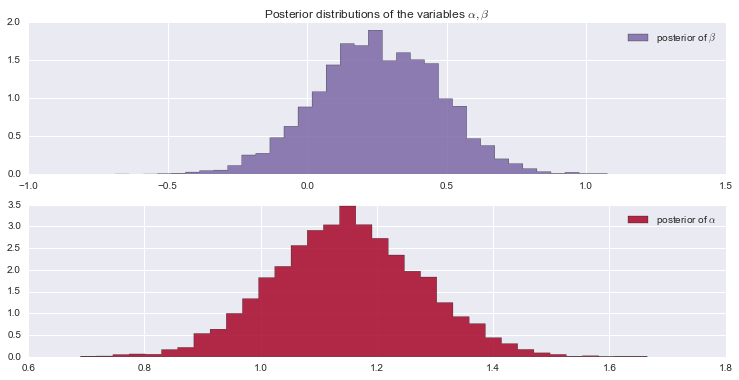

In [13]:
alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]

figsize(12.5, 6)

#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend();

In [14]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

t = np.linspace(levels.min() - 10, levels.max()+10, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

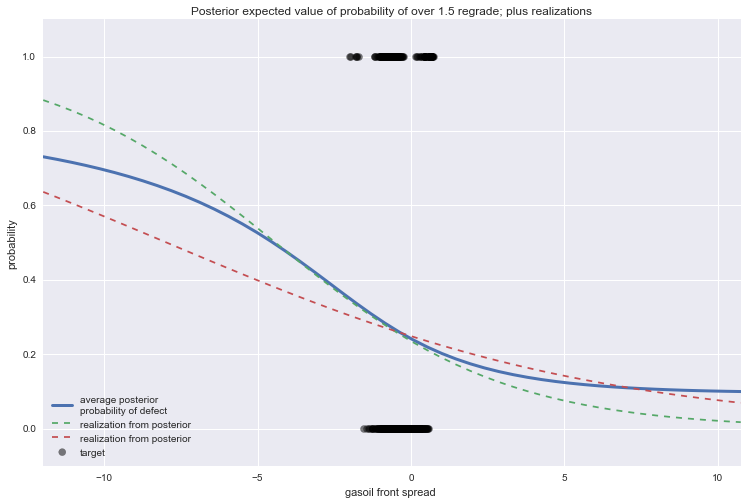

In [15]:
figsize(12.5, 8)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(levels, D, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of over 1.5 regrade; \
plus realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("gasoil front spread ");

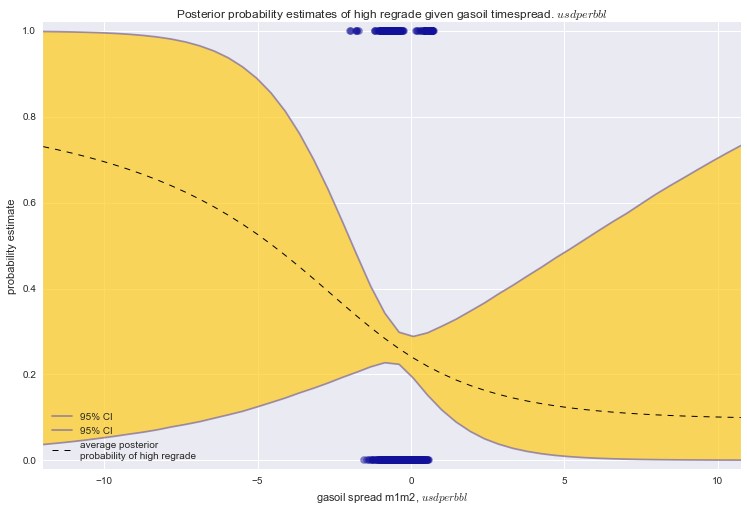

In [31]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#ffcc19")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)
plt.plot(t[:, 0], qs[-1], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of high regrade")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(levels, D, color="#111199", s=50, alpha=0.5)
plt.xlabel("gasoil spread m1m2, $usd per bbl$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates of high regrade given gasoil timespread. $usd per bbl$");

Conclusions:

After applying MCMC techinques and a bayesian logistic regression classifier model we did not find a significative relationship between gasoil intermonth spreads and occurences of high regrade (kerosene to gasoil spreads over 1.5 uad per bbl). We only see a slight bias that at higher gasoil spreads highs regrades are less likely to occur.

At the same time the last graph is an informative illustration of the certainty of probability estimates: high regrade occurs with in 0.25 - 0.30 probabilities around levels of gasoil spreads for which we have observed samples. When we get far out of the observed sample range we see how our CI credible interval get wide and we are less certain of our probability estimate of a high regrade event conditionned on the gasoil spread level.